In [1]:
# %pip install pandas
# %pip install polars
# %pip install pyarrow

In [2]:
import pandas as pd
import polars as pl

# Load Data


In [3]:
tweets = pl.read_parquet('./master_fnn.parquet')

In [4]:
users = pl.read_csv('../database/master_users.csv')


# Analysis


## Frequency

In [5]:
text_length_time_series = tweets.select([
  pl.col('text').str.split(' ').arr.lengths(),
  pl.col('created_at').dt.year(),
]).groupby('created_at').count().sort('created_at')

text_length_time_series_true = tweets.filter(pl.col('label') == 'true').select([
  pl.col('text').str.split(' ').arr.lengths(),
  pl.col('created_at').dt.year(),
]).groupby('created_at').count().sort('created_at')

text_length_time_series_false = tweets.filter(pl.col('label') == 'false').select([
  pl.col('text').str.split(' ').arr.lengths(),
  pl.col('created_at').dt.year(),
]).groupby('created_at').count().sort('created_at')

text_length_time_series = text_length_time_series.join(text_length_time_series_true, on='created_at', how='left', suffix='_true').join(text_length_time_series_false, on='created_at', how='left', suffix='_false')
text_length_time_series

shape: (12, 4)
┌────────────┬────────┬────────────┬─────────────┐
│ created_at ┆ count  ┆ count_true ┆ count_false │
│ ---        ┆ ---    ┆ ---        ┆ ---         │
│ i32        ┆ u32    ┆ u32        ┆ u32         │
╞════════════╪════════╪════════════╪═════════════╡
│ 2007       ┆ 66     ┆ 65         ┆ 1           │
│ 2008       ┆ 382    ┆ 320        ┆ 62          │
│ 2009       ┆ 3503   ┆ 2532       ┆ 971         │
│ 2010       ┆ 7017   ┆ 4046       ┆ 2971        │
│ …          ┆ …      ┆ …          ┆ …           │
│ 2015       ┆ 33212  ┆ 12232      ┆ 20980       │
│ 2016       ┆ 71267  ┆ 25731      ┆ 45536       │
│ 2017       ┆ 529283 ┆ 411802     ┆ 117481      │
│ 2018       ┆ 717996 ┆ 472322     ┆ 245674      │
└────────────┴────────┴────────────┴─────────────┘

In [6]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=text_length_time_series['created_at'], y=text_length_time_series['count'],
                    mode='lines+markers',
                    name='All'))
fig.add_trace(go.Scatter(x=text_length_time_series['created_at'], y=text_length_time_series['count_true'],
                    mode='lines+markers',
                    name='False'))
fig.add_trace(go.Scatter(x=text_length_time_series['created_at'], y=text_length_time_series['count_false'],
                    mode='lines+markers',
                    name='True'))

fig.update_layout(title='Text Record Count Time Series', height=600, width=800)
fig.write_image("./output/text_frequency_time_series.png")

fig.show()

## Word Cloud


In [7]:
from collections import Counter

In [8]:
# True Word
counter_all = Counter([word for sentence in tweets.select([
    pl.col('label'),
    pl.col('processed_text'),
])['processed_text'].to_list() for word in sentence])

# filter with frequent word
counter_all = {k: v for k, v in sorted(counter_all.items(), key=lambda item: item[1], reverse=True)}

# Get the q1 and q3 word of more than 1000 word sentense
counter_1000 = pd.Series(filter(lambda x: x > 1000, list(counter_all.values())))

q1 = counter_1000.quantile(0.25)
q3 = counter_1000.quantile(0.75)

counter_all_1000_iqr = {k: v for k, v in counter_all.items() if v > q1 and v < q3}

In [9]:
# True Word
counter_true = Counter([word for sentence in tweets.filter(pl.col('label') == 'true').select([
    pl.col('label'),
    pl.col('processed_text'),
])['processed_text'].to_list() for word in sentence])

# filter with frequent word
counter_true = {k: v for k, v in sorted(counter_true.items(), key=lambda item: item[1], reverse=True)}

# Get the q1 and q3 word of more than 1000 word sentense
counter_1000 = pd.Series(filter(lambda x: x > 1000, list(counter_true.values())))

q1 = counter_1000.quantile(0.25)
q3 = counter_1000.quantile(0.75)

counter_true_1000_iqr = {k: v for k, v in counter_true.items() if v > q1 and v < q3}

In [10]:
# True Word
counter_false = Counter([word for sentence in tweets.filter(pl.col('label') == 'false').select([
    pl.col('label'),
    pl.col('processed_text'),
])['processed_text'].to_list() for word in sentence])

# filter with frequent word
counter_false = {k: v for k, v in sorted(counter_false.items(), key=lambda item: item[1], reverse=True)}

# Get the q1 and q3 word of more than 1000 word sentense
counter_1000 = pd.Series(filter(lambda x: x > 1000, list(counter_false.values())))

q1 = counter_1000.quantile(0.25)
q3 = counter_1000.quantile(0.75)

counter_false_1000_iqr = {k: v for k, v in counter_false.items() if v > q1 and v < q3}

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

### Word Cloud on Tweets Content


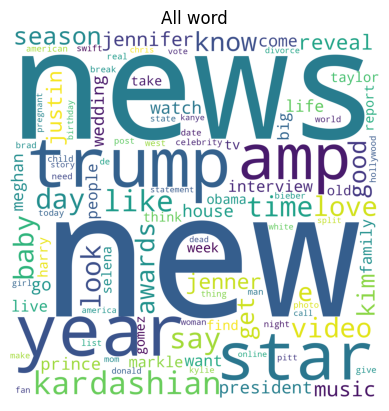

In [12]:
wc = WordCloud(background_color="white",width=2048,height=2048, max_words=100, normalize_plurals=False).generate_from_frequencies(counter_all)
plt.title('All word')
plt.axis('off')
plt.imshow(wc)
plt.savefig('./output/wc_word_all.png')

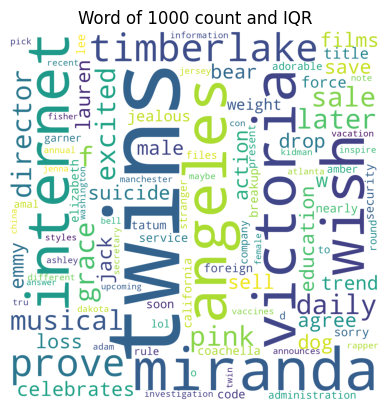

In [13]:
wc = WordCloud(background_color="white",width=2048,height=2048, max_words=100, normalize_plurals=False).generate_from_frequencies(counter_all_1000_iqr)
plt.title('Word of 1000 count and IQR')
plt.axis('off')
plt.imshow(wc)
plt.savefig('./output/wc_word_all_1000.png')

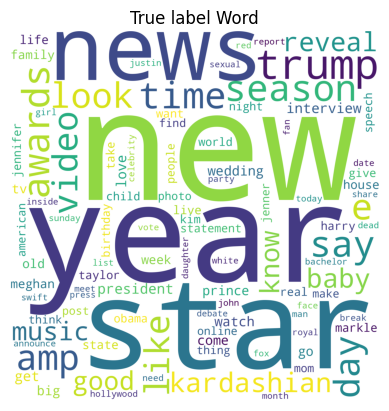

In [14]:
wc = WordCloud(background_color="white",width=2048,height=2048, max_words=100, normalize_plurals=False).generate_from_frequencies(counter_true)
plt.title('True label Word')
plt.axis('off')
plt.imshow(wc)
plt.savefig('./output/wc_word_true.png')

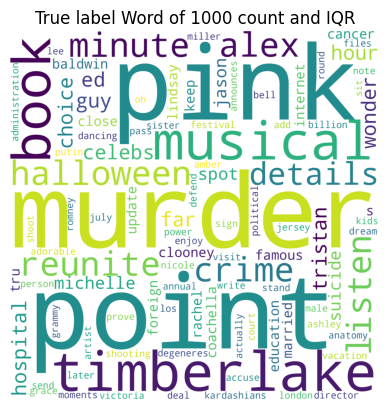

In [15]:
wc = WordCloud(background_color="white",width=2048,height=2048, max_words=100, normalize_plurals=False).generate_from_frequencies(counter_true_1000_iqr)
plt.title('True label Word of 1000 count and IQR')
plt.axis('off')
plt.imshow(wc)
plt.savefig('./output/wc_word_true_1000.png')

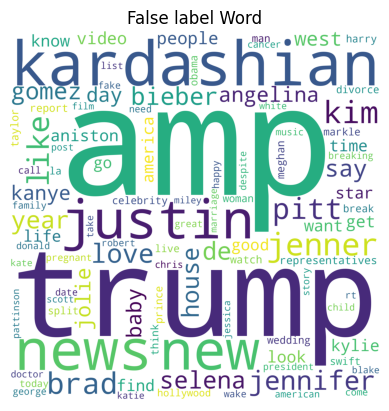

In [16]:
wc = WordCloud(background_color="white",width=2048,height=2048, max_words=100, normalize_plurals=False).generate_from_frequencies(counter_false)
plt.title('False label Word')
plt.axis('off')
plt.imshow(wc)
plt.savefig('./output/wc_word_false.png')

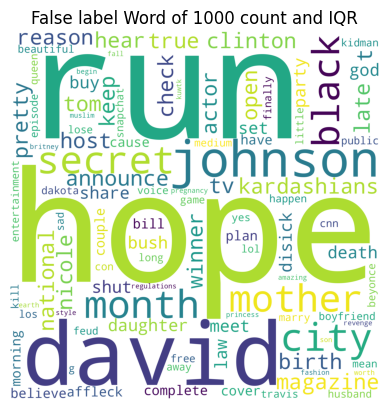

In [17]:
wc = WordCloud(background_color="white",width=2048,height=2048, max_words=100, normalize_plurals=False).generate_from_frequencies(counter_false_1000_iqr)
plt.title('False label Word of 1000 count and IQR')
plt.axis('off')
plt.imshow(wc)
plt.savefig('./output/wc_word_false_1000.png')

### Word Cloud on Tweets Context


In [18]:
annotation = tweets.select([
    pl.col('label'),
    pl.col('entities').struct.field('annotations')
]).explode('annotations').select([
    pl.col('label'),
    pl.col('annotations').struct.field('normalized_text')
])

annotation_type = tweets.select([
    pl.col('label'),
    pl.col('entities').struct.field('annotations')
]).explode('annotations').select([
    pl.col('label'),
    pl.col('annotations').struct.field('type')
])


In [19]:
counter_annotation = Counter(annotation['normalized_text'].to_list())

# filter with frequent word
counter_annotation = {k: v for k, v in sorted(counter_annotation.items(), key=lambda item: item[1], reverse=True)}

# Get the q1 and q3 word of more than 1000 word sentense
counter_1000 = pd.Series(filter(lambda x: x > 1000, list(counter_annotation.values())))

q1 = counter_1000.quantile(0.25)
q3 = counter_1000.quantile(0.75)

counter_annotation = {k: v for k, v in counter_annotation.items() if k is not None}
counter_annotation_1000_iqr = {k: v for k, v in counter_annotation.items() if v > q1 and v < q3 and k is not None}

counter_annotation_true = Counter(annotation.filter(pl.col('label') == 'true')['normalized_text'].to_list())

# filter with frequent word
counter_annotation_true = {k: v for k, v in sorted(counter_annotation_true.items(), key=lambda item: item[1], reverse=True)}

# Get the q1 and q3 word of more than 1000 word sentense
counter_1000 = pd.Series(filter(lambda x: x > 1000, list(counter_annotation_true.values())))

q1 = counter_1000.quantile(0.25)
q3 = counter_1000.quantile(0.75)

counter_annotation_true = {k: v for k, v in counter_annotation_true.items() if k is not None}
counter_annotation_true_1000_iqr = {k: v for k, v in counter_annotation_true.items() if v > q1 and v < q3 and k is not None}

counter_annotation_false = Counter(annotation.filter(pl.col('label') == 'false')['normalized_text'].to_list())

# filter with frequent word
counter_annotation_false = {k: v for k, v in sorted(counter_annotation_false.items(), key=lambda item: item[1], reverse=True)}

# Get the q1 and q3 word of more than 1000 word sentense
counter_1000 = pd.Series(filter(lambda x: x > 1000, list(counter_annotation_false.values())))

q1 = counter_1000.quantile(0.25)
q3 = counter_1000.quantile(0.75)

counter_annotation_false = {k: v for k, v in counter_annotation_false.items() if k is not None}
counter_annotation_false_1000_iqr = {k: v for k, v in counter_annotation_false.items() if v > q1 and v < q3 and k is not None}

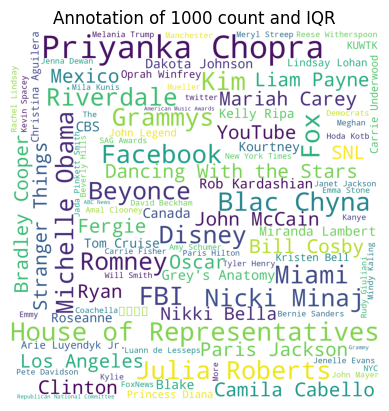

In [20]:
wc = WordCloud(background_color="white",width=2048,height=2048, max_words=100, normalize_plurals=False).generate_from_frequencies(counter_annotation)
plt.title('Annotation')
plt.axis('off')
plt.imshow(wc)
plt.savefig('./output/wc_annotation_all.png')

wc = WordCloud(background_color="white",width=2048,height=2048, max_words=100, normalize_plurals=False).generate_from_frequencies(counter_annotation_1000_iqr)
plt.title('Annotation of 1000 count and IQR')
plt.axis('off')
plt.imshow(wc)
plt.savefig('./output/wc_annotation_all_1000_iqr.png')

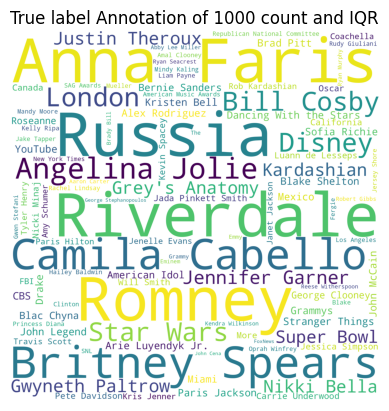

In [21]:
wc = WordCloud(background_color="white",width=2048,height=2048, max_words=100, normalize_plurals=False).generate_from_frequencies(counter_annotation_true)
plt.title('True label Annotation')
plt.axis('off')
plt.imshow(wc)
plt.savefig('./output/wc_annotation_true.png')

wc = WordCloud(background_color="white",width=2048,height=2048, max_words=100, normalize_plurals=False).generate_from_frequencies(counter_annotation_true_1000_iqr)
plt.title('True label Annotation of 1000 count and IQR')
plt.axis('off')
plt.imshow(wc)
plt.savefig('./output/wc_annotation_true_1000_iqr.png')

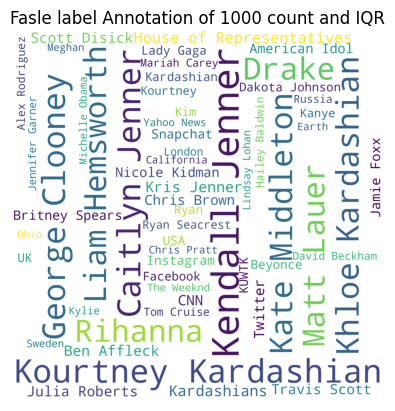

In [22]:
wc = WordCloud(background_color="white",width=2048,height=2048, max_words=100, normalize_plurals=False).generate_from_frequencies(counter_annotation_false)
plt.title('Fasle label Annotation')
plt.axis('off')
plt.imshow(wc)
plt.savefig('./output/wc_annotation_false.png')

wc = WordCloud(background_color="white",width=2048,height=2048, max_words=100, normalize_plurals=False).generate_from_frequencies(counter_annotation_false_1000_iqr)
plt.title('Fasle label Annotation of 1000 count and IQR')
plt.axis('off')
plt.imshow(wc)
plt.savefig('./output/wc_annotation_false_1000_iqr.png')

In [23]:
import plotly.express as px


In [24]:
fig = px.bar(pd.DataFrame(list(counter_annotation.items())[:10], columns=['word', 'count']), x="word", y="count", title='Annotation of all annotaiton entity')
fig.update_layout(height=600, width=800)
fig.show()


In [25]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=3, cols=1, subplot_titles=("All Label","True Label", "False Label"))

fig.append_trace(go.Bar(y=list(counter_annotation.values())[:10] ,x=list(counter_annotation.keys())[:10]), row=1, col=1)

fig.append_trace(go.Bar(y=list(counter_annotation_true.values())[:10] ,x=list(counter_annotation_true.keys())[:10]), row=2, col=1)

fig.append_trace(go.Bar(y=list(counter_annotation_false.values())[:10] ,x=list(counter_annotation_false.keys())[:10]), row=3, col=1)

fig.update_layout(showlegend=False, title_text="Annotations")

fig.update_layout(height=600, width=600, title_text="Annotation Word Count (Top 10)")
fig.write_image("./output/annotation_bar.png")
fig.show()


In [26]:
counter_type = Counter(annotation_type['type'].to_list())

# filter with frequent word
counter_type = {k: v for k, v in sorted(counter_type.items(), key=lambda item: item[1], reverse=True)}

# Get the q1 and q3 word of more than 1000 word sentense
counter_1000 = pd.Series(filter(lambda x: x > 1000, list(counter_type.values())))

q1 = counter_1000.quantile(0.25)
q3 = counter_1000.quantile(0.75)

counter_type = {k: v for k, v in counter_type.items() if k is not None}
counter_type_1000_iqr = {k: v for k, v in counter_type.items() if v > q1 and v < q3 and k is not None}

counter_type_true = Counter(annotation_type.filter(pl.col('label') == 'true')['type'].to_list())

# filter with frequent word
counter_type_true = {k: v for k, v in sorted(counter_type_true.items(), key=lambda item: item[1], reverse=True)}

# Get the q1 and q3 word of more than 1000 word sentense
counter_1000 = pd.Series(filter(lambda x: x > 1000, list(counter_type_true.values())))

q1 = counter_1000.quantile(0.25)
q3 = counter_1000.quantile(0.75)

counter_type_true = {k: v for k, v in counter_type_true.items() if k is not None}
counter_type_true_1000_iqr = {k: v for k, v in counter_type_true.items() if v > q1 and v < q3 and k is not None}

counter_type_false = Counter(annotation_type.filter(pl.col('label') == 'false')['type'].to_list())

# filter with frequent word
counter_type_false = {k: v for k, v in sorted(counter_type_false.items(), key=lambda item: item[1], reverse=True)}

# Get the q1 and q3 word of more than 1000 word sentense
counter_1000 = pd.Series(filter(lambda x: x > 1000, list(counter_type_false.values())))

q1 = counter_1000.quantile(0.25)
q3 = counter_1000.quantile(0.75)

counter_type_false = {k: v for k, v in counter_type_false.items() if k is not None}
counter_type_false_1000_iqr = {k: v for k, v in counter_type_false.items() if v > q1 and v < q3 and k is not None}

In [27]:
print("all\t", counter_type)
print("true\t", counter_type_true)
print("false\t", counter_type_false)

all	 {'Person': 1857737, 'Other': 942644, 'Place': 291156, 'Organization': 250716, 'Product': 1712}
true	 {'Person': 1264016, 'Other': 688477, 'Place': 201100, 'Organization': 183459, 'Product': 1187}
false	 {'Person': 593721, 'Other': 254167, 'Place': 90056, 'Organization': 67257, 'Product': 525}


/tmp/ipykernel_19605/3416681138.py:18: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



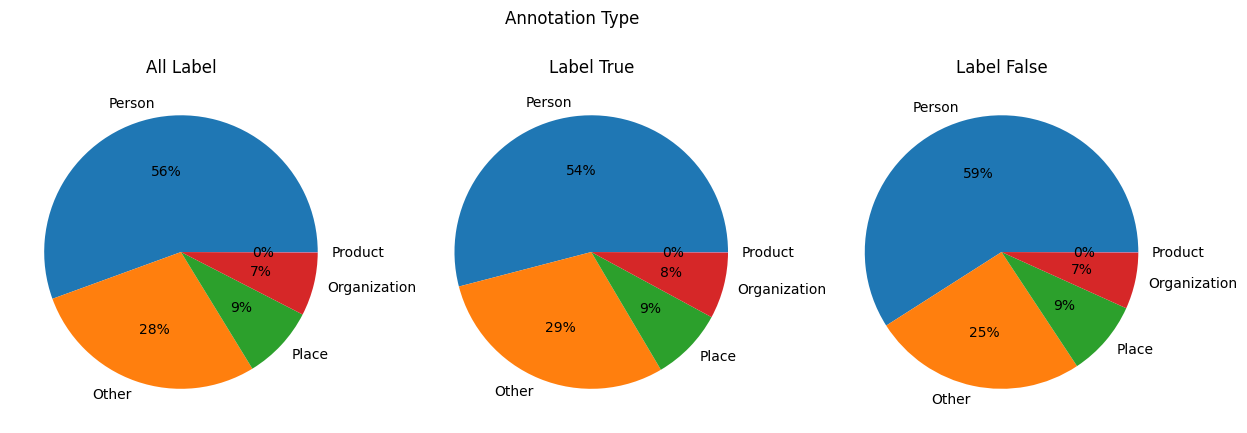

In [28]:
fig = plt.figure(figsize=(15, 5))

ax0 = fig.add_subplot(1, 3, 1)

ax0.pie(list(counter_type.values()), labels = list(counter_type.keys()), autopct='%.0f%%')
ax0.set_title("All Label")

ax1 = fig.add_subplot(1, 3, 2)

ax1.pie(list(counter_type_true.values()), labels = list(counter_type_true.keys()), autopct='%.0f%%')
ax1.set_title("Label True")

ax2 = fig.add_subplot(1, 3, 3)
ax2.pie(list(counter_type_false.values()), labels = list(counter_type_false.keys()), autopct='%.0f%%')
ax2.set_title("Label False")

fig.suptitle('Annotation Type')
fig.show()

### Word Cloud on Tag


In [29]:
tag = tweets.select([
    pl.col('label'),
    pl.col('entities').struct.field('hashtags')
]).explode('hashtags').select([
    pl.col('label'),
    pl.col('hashtags').struct.field('tag')
]).filter(pl.col('tag').is_not_null())

In [30]:
counter_tag = Counter(tag['tag'].to_list())

# filter with frequent word
counter_tag = {k: v for k, v in sorted(counter_tag.items(), key=lambda item: item[1], reverse=True)}

# Get the q1 and q3 word of more than 1000 word sentense
counter_1000 = pd.Series(filter(lambda x: x > 1000, list(counter_tag.values())))

q1 = counter_1000.quantile(0.25)
q3 = counter_1000.quantile(0.75)

counter_tag = {k: v for k, v in counter_tag.items() if k is not None}
counter_tag_without_one = {k: v for k, v in counter_tag.items() if k is not None and v > 1}
counter_tag_1000_iqr = {k: v for k, v in counter_tag.items() if v > q1 and v < q3 and k is not None}

counter_tag_true = Counter(tag.filter(pl.col('label') == 'true')['tag'].to_list())

# filter with frequent word
counter_tag_true = {k: v for k, v in sorted(counter_tag_true.items(), key=lambda item: item[1], reverse=True)}

# Get the q1 and q3 word of more than 1000 word sentense
counter_1000 = pd.Series(filter(lambda x: x > 1000, list(counter_tag_true.values())))

q1 = counter_1000.quantile(0.25)
q3 = counter_1000.quantile(0.75)

counter_tag_true = {k: v for k, v in counter_tag_true.items() if k is not None}
counter_tag_true_without_one = {k: v for k, v in counter_tag_true.items() if k is not None and v > 1}
counter_tag_true_1000_iqr = {k: v for k, v in counter_tag_true.items() if v > q1 and v < q3 and k is not None}

counter_tag_false = Counter(tag.filter(pl.col('label') == 'false')['tag'].to_list())

# filter with frequent word
counter_tag_false = {k: v for k, v in sorted(counter_tag_false.items(), key=lambda item: item[1], reverse=True)}

# Get the q1 and q3 word of more than 1000 word sentense
counter_1000 = pd.Series(filter(lambda x: x > 1000, list(counter_tag_false.values())))

q1 = counter_1000.quantile(0.25)
q3 = counter_1000.quantile(0.75)

counter_tag_false = {k: v for k, v in counter_tag_false.items() if k is not None}
counter_tag_false_without_one = {k: v for k, v in counter_tag_false.items() if k is not None and v > 1}
counter_tag_false_1000_iqr = {k: v for k, v in counter_tag_false.items() if v > q1 and v < q3 and k is not None}

In [31]:
print("all\t", counter_tag)
print("true\t", counter_tag_true)
print("false\t", counter_tag_false)

all	 {'entertainment': 8711, 'news': 5876, 'Moda': 5038, 'celebrity': 5018, 'News': 3067, 'music': 2464, 'BreakingNews': 2330, 'ほろよい': 2314, 'gossip': 2049, 'WakeUpAmerica': 2040, 'Entertainmentnews': 1842, 'Entretenimiento': 1827, 'Entertainment': 1678, 'Trump': 1612, 'jamjamtv': 1595, 'FoxNews': 1559, 'MODA': 1422, 'KUWTK': 1361, 'MeToo': 1289, 'MAGA': 1184, 'fashion': 1169, 'Vida': 1136, '花火とほろよい': 1092, 'EOnline': 1024, 'Celebrity': 996, 'bancodeseries': 994, 'movies': 979, 'SelenaGomez': 956, 'USA': 952, 'KimKardashian': 911, 'Celebrities': 898, 'US': 861, 'BradPitt': 847, 'celebs': 835, 'tcot': 830, 'sweepstakes': 812, 'Hollywood': 802, 'hollywood': 802, 'comedy': 795, 'celebrities': 778, 'JustinBieber': 773, 'blog': 766, 'MeghanMarkle': 753, 'internet': 750, 'artists': 748, 'SocialMedia': 731, 'SmartNews': 727, 'Music': 719, 'NowPlaying': 691, 'Twitter': 684, 'CNN': 668, 'Snapchat': 663, 'KanyeWest': 658, 'Marketing': 653, 'AngelinaJolie': 644, 'streetpolynews': 620, 'Eonline': 

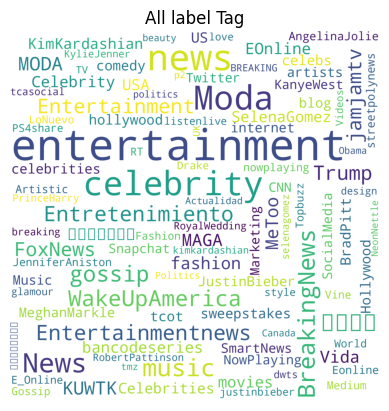

In [32]:
wc = WordCloud(background_color="white",width=2048,height=2048, max_words=100, normalize_plurals=False).generate_from_frequencies(counter_tag)
plt.title('All label Tag')
plt.axis('off')
plt.imshow(wc)
plt.savefig('./output/wc_tag_all.png')

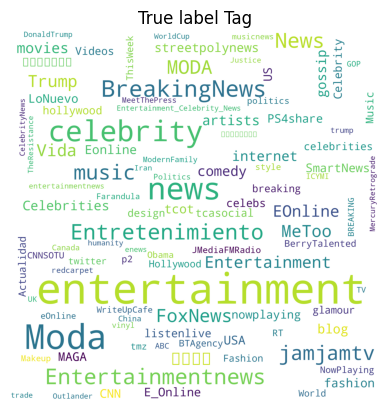

In [33]:
wc = WordCloud(background_color="white",width=2048,height=2048, max_words=100, normalize_plurals=False).generate_from_frequencies(counter_tag_true)
plt.title('True label Tag')
plt.axis('off')
plt.imshow(wc)
plt.savefig('./output/wc_tag_true.png')

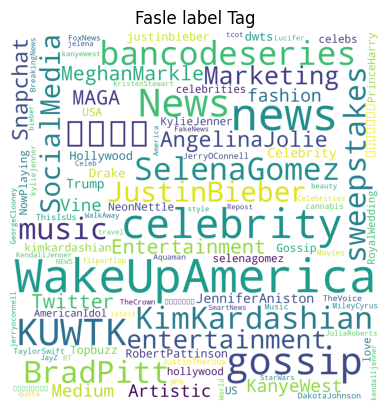

In [34]:
wc = WordCloud(background_color="white",width=2048,height=2048, max_words=100, normalize_plurals=False).generate_from_frequencies(counter_tag_false)
plt.title('Fasle label Tag')
plt.axis('off')
plt.imshow(wc)
plt.savefig('./output/wc_tag_false.png')

In [35]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=3, cols=1, subplot_titles=("All Label","True Label", "False Label"))

fig.append_trace(go.Bar(y=list(counter_tag.values())[:10] ,x=list(counter_tag.keys())[:10]), row=1, col=1)

fig.append_trace(go.Bar(y=list(counter_tag_true.values())[:10] ,x=list(counter_tag_true.keys())[:10]), row=2, col=1)

fig.append_trace(go.Bar(y=list(counter_tag_false.values())[:10] ,x=list(counter_tag_false.keys())[:10]), row=3, col=1)

fig.update_layout(showlegend=False, title_text="Annotations")

fig.update_layout(height=600, width=600, title_text="Tag Count (Top 10)")
fig.write_image("./output/tag_bar.png")
fig.show()


In [36]:
text_length = tweets.select([
    pl.col('label'),
    pl.col('text').str.split(' ').arr.lengths(),
])

text_length_true = tweets.select([
    pl.col('label'),
    pl.col('text').str.split(' ').arr.lengths(),
]).filter(pl.col('label') == 'true')

text_length_false = tweets.select([
    pl.col('label'),
    pl.col('text').str.split(' ').arr.lengths(),
]).filter(pl.col('label') == 'false')

In [37]:
text_length.describe()

shape: (7, 3)
┌────────────┬─────────┬────────────┐
│ describe   ┆ label   ┆ text       │
│ ---        ┆ ---     ┆ ---        │
│ str        ┆ str     ┆ f64        │
╞════════════╪═════════╪════════════╡
│ count      ┆ 1434575 ┆ 1.434575e6 │
│ null_count ┆ 0       ┆ 0.0        │
│ mean       ┆ null    ┆ 20.464996  │
│ std        ┆ null    ┆ 11.765089  │
│ min        ┆ false   ┆ 1.0        │
│ max        ┆ true    ┆ 175.0      │
│ median     ┆ null    ┆ 17.0       │
└────────────┴─────────┴────────────┘

In [38]:
text_length_true.describe()

shape: (7, 3)
┌────────────┬────────┬───────────┐
│ describe   ┆ label  ┆ text      │
│ ---        ┆ ---    ┆ ---       │
│ str        ┆ str    ┆ f64       │
╞════════════╪════════╪═══════════╡
│ count      ┆ 956506 ┆ 956506.0  │
│ null_count ┆ 0      ┆ 0.0       │
│ mean       ┆ null   ┆ 21.50889  │
│ std        ┆ null   ┆ 12.232454 │
│ min        ┆ true   ┆ 1.0       │
│ max        ┆ true   ┆ 168.0     │
│ median     ┆ null   ┆ 17.0      │
└────────────┴────────┴───────────┘

In [39]:
text_length_false.describe()

shape: (7, 3)
┌────────────┬────────┬───────────┐
│ describe   ┆ label  ┆ text      │
│ ---        ┆ ---    ┆ ---       │
│ str        ┆ str    ┆ f64       │
╞════════════╪════════╪═══════════╡
│ count      ┆ 478069 ┆ 478069.0  │
│ null_count ┆ 0      ┆ 0.0       │
│ mean       ┆ null   ┆ 18.376404 │
│ std        ┆ null   ┆ 10.461128 │
│ min        ┆ false  ┆ 1.0       │
│ max        ┆ false  ┆ 175.0     │
│ median     ┆ null   ┆ 16.0      │
└────────────┴────────┴───────────┘

In [40]:
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Box(y=text_length['text'], name="All Label"))
fig.add_trace(go.Box(y=text_length_true['text'], name="True Label"))
fig.add_trace(go.Box(y=text_length_false['text'], name="False Label"))

fig.update_layout(height=600, width=600, title_text="Text Length")
fig.write_image("./output/text_length_box.png")
# fig.show()

In [41]:
text_length_time_series = tweets.select([
  pl.col('text').str.split(' ').arr.lengths(),
  pl.col('created_at').dt.year(),
]).groupby('created_at').agg([pl.col("text").mean()]).sort('created_at')

text_length_time_series_true = tweets.filter(pl.col('label') == 'true').select([
  pl.col('text').str.split(' ').arr.lengths(),
  pl.col('created_at').dt.year(),
]).groupby('created_at').agg([pl.col("text").mean()]).sort('created_at')

text_length_time_series_false = tweets.filter(pl.col('label') == 'false').select([
  pl.col('text').str.split(' ').arr.lengths(),
  pl.col('created_at').dt.year(),
]).groupby('created_at').agg([pl.col("text").mean()]).sort('created_at')

In [42]:
text_length_time_series = text_length_time_series.join(text_length_time_series_true, on='created_at', how='left', suffix='_true').join(text_length_time_series_false, on='created_at', how='left', suffix='_false')
text_length_time_series.describe()

shape: (7, 5)
┌────────────┬────────────┬───────────┬───────────┬────────────┐
│ describe   ┆ created_at ┆ text      ┆ text_true ┆ text_false │
│ ---        ┆ ---        ┆ ---       ┆ ---       ┆ ---        │
│ str        ┆ f64        ┆ f64       ┆ f64       ┆ f64        │
╞════════════╪════════════╪═══════════╪═══════════╪════════════╡
│ count      ┆ 12.0       ┆ 12.0      ┆ 12.0      ┆ 12.0       │
│ null_count ┆ 0.0        ┆ 0.0       ┆ 0.0       ┆ 0.0        │
│ mean       ┆ 2012.5     ┆ 17.260809 ┆ 17.473249 ┆ 16.743868  │
│ std        ┆ 3.605551   ┆ 2.439375  ┆ 2.861098  ┆ 1.802328   │
│ min        ┆ 2007.0     ┆ 15.239031 ┆ 15.454666 ┆ 15.080645  │
│ max        ┆ 2018.0     ┆ 24.313375 ┆ 25.959083 ┆ 21.149409  │
│ median     ┆ 2012.5     ┆ 16.54933  ┆ 16.747593 ┆ 16.135432  │
└────────────┴────────────┴───────────┴───────────┴────────────┘

In [43]:
import plotly.graph_objects as go
import numpy as np
np.random.seed(1)

fig = go.Figure()
fig.add_trace(go.Box(y=text_length_time_series['text'], name="All Label"))
fig.add_trace(go.Box(y=text_length_time_series['text_true'], name="True Label"))
fig.add_trace(go.Box(y=text_length_time_series['text_false'], name="False Label"))

fig.update_layout(height=600, width=600, title_text="Text Length Time Series Distribution")
fig.write_image("./output/text_length_time_seriers_avg.png")

fig.show()

In [44]:
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Scatter(x=text_length_time_series_true['created_at'], y=text_length_time_series_true['text'],
                    mode='lines+markers',
                    name='False'))
fig.add_trace(go.Scatter(x=text_length_time_series_false['created_at'], y=text_length_time_series_false['text'],
                    mode='lines+markers',
                    name='True'))

fig.update_layout(height=600, width=600, title='Average Text Length Time Series')
fig.write_image("./output/text_length_time_seriers_avg.png")

fig.show()